In [9]:
import numpy as np
import cv2

img = cv2.imread("images/tomatoes.jpg",1)

hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
res, thresh = cv2.threshold(hsv[:, :, 0], 25, 255, cv2.THRESH_BINARY_INV)

edges = cv2.Canny(img, 100, 200, apertureSize=3)

edge_inv = 255 - edges

# Use erosion to increase size of the 'border'
kernel = np.ones((3, 3), 'uint8')
erode = cv2.erode(edge_inv, kernel, iterations=1)

canny_thresh = cv2.bitwise_and(erode, thresh)
contours, hierarchy = cv2.findContours(
	canny_thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

def draw_contours(image, contours):
	objects = img.copy()
	for c in contours:
		area = cv2.contourArea(c)
		if area < 300:
			# This contour is around something too small for our interest
			continue
		print("Area: ", area)
		cv2.drawContours(objects, [c], -1, (255, 255, 255), 1)
		M = cv2.moments(c)
		cx = int(M['m10'] / M['m00'])
		cy = int(M['m01'] / M['m00'])
		cv2.circle(objects, (cx, cy), 4, (255, 255, 0), -1)
	return objects

objects = draw_contours(img, contours)

Area:  1788.5
Area:  1518.5
Area:  966.5
Area:  1436.0
Area:  517.5
Area:  6313.5
Area:  6930.0
Area:  307.0
Area:  2636.0
Area:  374.0


In [10]:
import matplotlib.pyplot as plt

def plot(images, titles):
    if len(images) != len(titles):
        raise ValueError("The number of images and titles must be the same.")
    
    cols = len(images)
    fig, axarr = plt.subplots(1, cols, figsize=(5 * cols, 5))

    for i in range(cols):
        ax = axarr[i] if cols > 1 else axarr
        ax.imshow(cv2.cvtColor(images[i], cv2.COLOR_BGR2RGB))
        ax.set_title(titles[i])
        ax.axis('off')

    plt.tight_layout()
    plt.show()

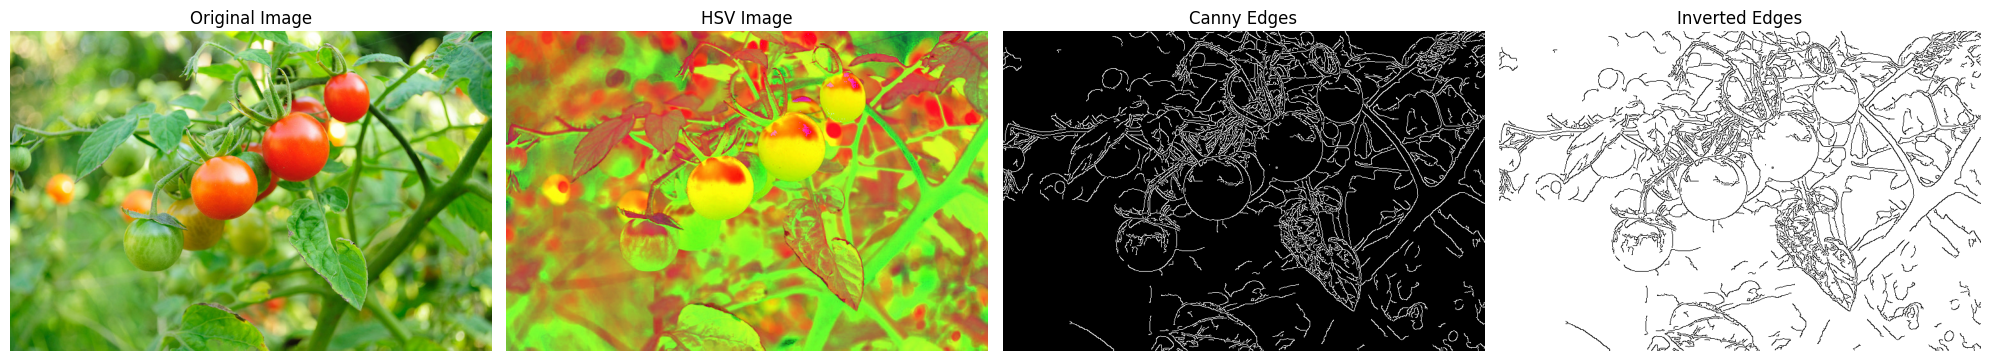

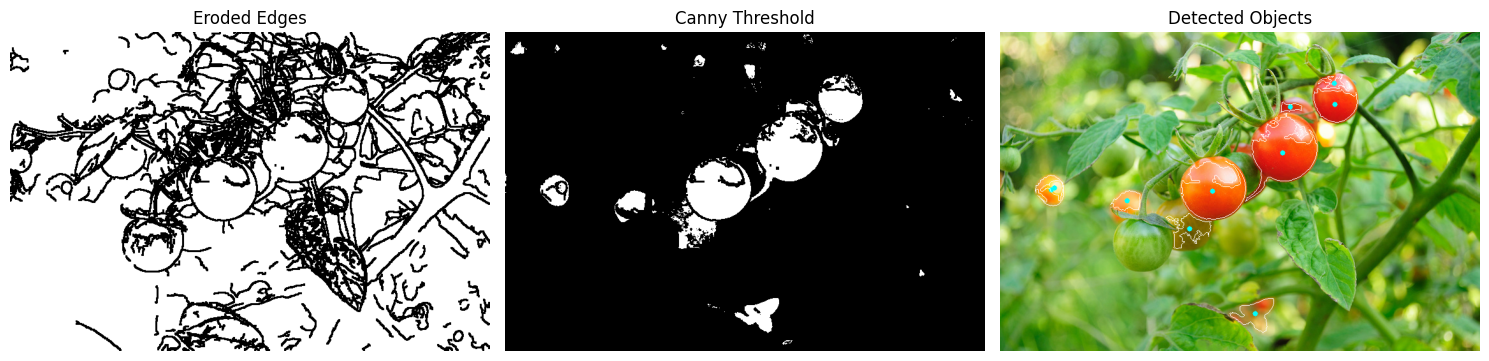

In [11]:
plot([img, hsv, edges, edge_inv],
     ["Original Image", "HSV Image", "Canny Edges", "Inverted Edges"])

plot([erode, canny_thresh, objects],
     ["Eroded Edges", "Canny Threshold", "Detected Objects"])

Total apples detected: 7


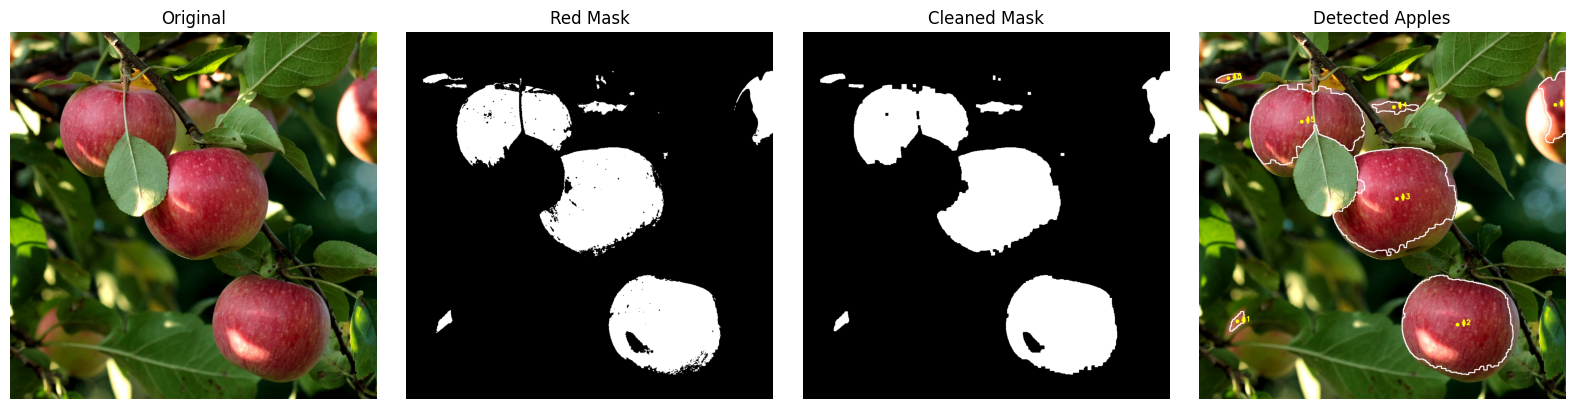

In [30]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

# Load image
img = cv2.imread("images/apples.jpg", 1)
hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)

# Define red hue ranges (2 parts: low reds & high reds)
lower_red1 = np.array([0, 100, 80])
upper_red1 = np.array([10, 255, 255])

lower_red2 = np.array([160, 100, 80])
upper_red2 = np.array([180, 255, 255])

# Create masks for red regions
mask1 = cv2.inRange(hsv, lower_red1, upper_red1)
mask2 = cv2.inRange(hsv, lower_red2, upper_red2)
red_mask = cv2.bitwise_or(mask1, mask2)

# Morphological cleaning (remove noise, fill holes)
kernel = np.ones((7, 7), np.uint8)
cleaned = cv2.morphologyEx(red_mask, cv2.MORPH_CLOSE, kernel)
cleaned = cv2.morphologyEx(cleaned, cv2.MORPH_OPEN, kernel)

# Find contours
contours, _ = cv2.findContours(cleaned, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Draw only valid contours (apples)
objects = img.copy()
apple_count = 0
for c in contours:
    area = cv2.contourArea(c)
    if area > 500:  # Ignore small regions (like sticks, noise)
        apple_count += 1
        cv2.drawContours(objects, [c], -1, (255, 255, 255), 2)
        M = cv2.moments(c)
        if M['m00'] != 0:
            cx = int(M['m10'] / M['m00'])
            cy = int(M['m01'] / M['m00'])
            cv2.circle(objects, (cx, cy), 5, (0, 255, 255), -1)
            cv2.putText(objects, f"#{apple_count}", (cx + 10, cy),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 255, 255), 2)

print(f"Total apples detected: {apple_count}")

# Plot results
def plot(images, titles):
    plt.figure(figsize=(16, 4))
    for i in range(len(images)):
        img_rgb = cv2.cvtColor(images[i], cv2.COLOR_BGR2RGB) if len(images[i].shape) == 3 else images[i]
        plt.subplot(1, len(images), i + 1)
        plt.imshow(img_rgb, cmap='gray' if len(images[i].shape) == 2 else None)
        plt.title(titles[i])
        plt.axis('off')
    plt.tight_layout()
    plt.show()

plot([img, red_mask, cleaned, objects], ['Original', 'Red Mask', 'Cleaned Mask', 'Detected Apples'])


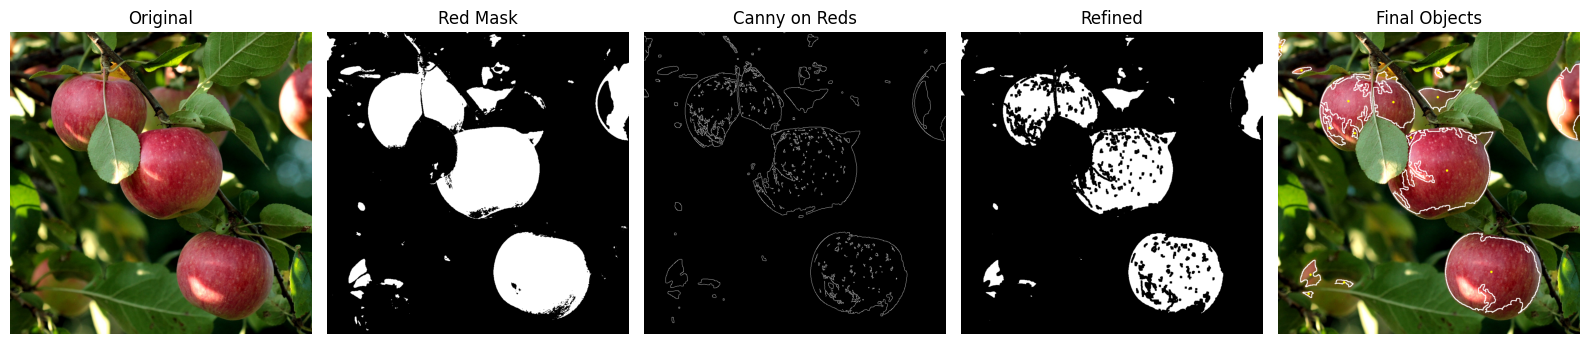

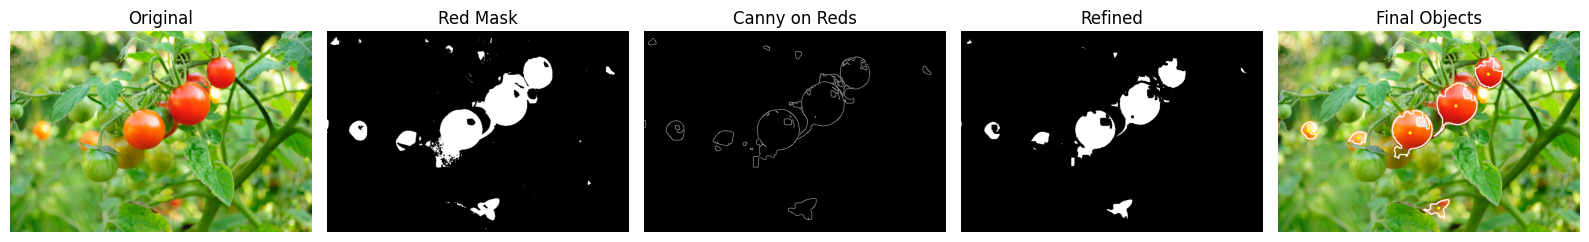

In [42]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

def detect_red(img):
    # Convert to HSV
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)

    # Dual red color range (low red + high red)
    lower_red1 = np.array([0, 50, 80])
    upper_red1 = np.array([25, 255, 255])
    lower_red2 = np.array([160, 50, 80])
    upper_red2 = np.array([180, 255, 255])

    # Build the red mask
    mask1 = cv2.inRange(hsv, lower_red1, upper_red1)
    mask2 = cv2.inRange(hsv, lower_red2, upper_red2)
    red_mask = cv2.bitwise_or(mask1, mask2)

    # Morphology to remove noise
    kernel = np.ones((5, 5), np.uint8)
    clean_mask = cv2.morphologyEx(red_mask, cv2.MORPH_OPEN, kernel)
    clean_mask = cv2.morphologyEx(clean_mask, cv2.MORPH_CLOSE, kernel)

    # Apply Canny only to red regions
    masked_img = cv2.bitwise_and(img, img, mask=clean_mask)
    gray = cv2.cvtColor(masked_img, cv2.COLOR_BGR2GRAY)
    edges = cv2.Canny(gray, 60, 160)

    # Combine edges and mask
    edge_inv = 255 - edges
    refined = cv2.bitwise_and(edge_inv, clean_mask)

    # Erode to smooth contours
    refined = cv2.erode(refined, kernel, iterations=1)

    # Find contours
    contours, _ = cv2.findContours(refined, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Draw final objects
    objects = img.copy()
    for i, c in enumerate(contours):
        area = cv2.contourArea(c)
        if area > 300:
            cv2.drawContours(objects, [c], -1, (255, 255, 255), 2)
            M = cv2.moments(c)
            if M['m00'] != 0:
                cx = int(M['m10'] / M['m00'])
                cy = int(M['m01'] / M['m00'])
                cv2.circle(objects, (cx, cy), 4, (0, 255, 255), -1)

    plot([img, red_mask, edges, refined, objects],
        ["Original", "Red Mask", "Canny on Reds", "Refined", "Final Objects"])


img = cv2.imread("images/apples.jpg", 1)
detect_red(img)

img = cv2.imread("images/tomatoes.jpg", 1) 
detect_red(img)

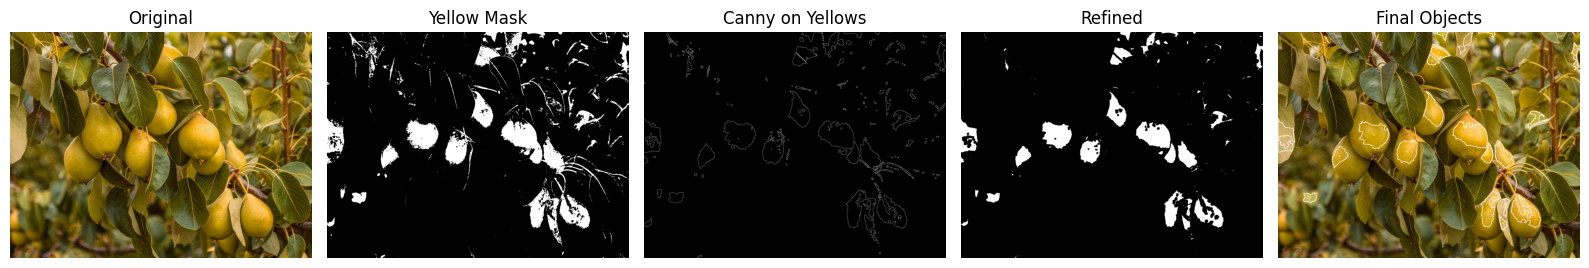

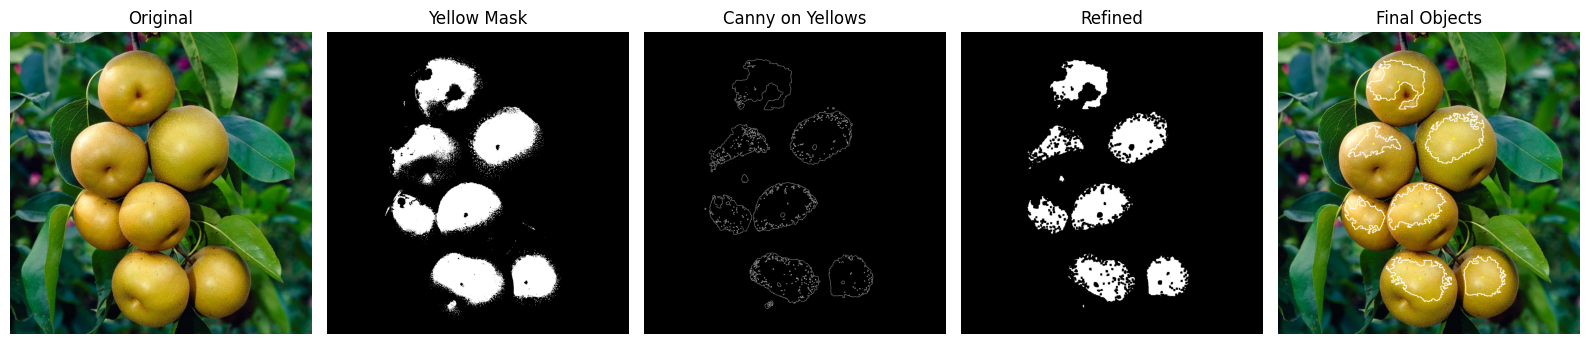

In [77]:
import numpy as np
import cv2


def detect_yellow(img):
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)

    # Selective yellow range
    lower_yellow = np.array([20, 100, 180])
    upper_yellow = np.array([35, 255, 255])

    yellow_mask = cv2.inRange(hsv, lower_yellow, upper_yellow)

    kernel = np.ones((5, 5), np.uint8)
    clean_mask = cv2.morphologyEx(yellow_mask, cv2.MORPH_OPEN, kernel)
    clean_mask = cv2.morphologyEx(clean_mask, cv2.MORPH_CLOSE, kernel)

    masked_img = cv2.bitwise_and(img, img, mask=clean_mask)
    gray = cv2.cvtColor(masked_img, cv2.COLOR_BGR2GRAY)
    edges = cv2.Canny(gray, 60, 160)

    edge_inv = 255 - edges
    refined = cv2.bitwise_and(edge_inv, clean_mask)
    refined = cv2.erode(refined, kernel, iterations=1)

    contours, _ = cv2.findContours(refined, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    objects = img.copy()
    for i, c in enumerate(contours):
        area = cv2.contourArea(c)
        if area < 500:
            continue

        # Shape filtering
        perimeter = cv2.arcLength(c, True)
        if perimeter == 0:
            continue

        # Mean hue inside contour
        mask = np.zeros(hsv.shape[:2], dtype=np.uint8)
        cv2.drawContours(mask, [c], -1, 255, -1)

        # Draw final contour
        cv2.drawContours(objects, [c], -1, (255, 255, 255), 2)
        M = cv2.moments(c)
        if M['m00'] != 0:
            cx = int(M['m10'] / M['m00'])
            cy = int(M['m01'] / M['m00'])
            cv2.circle(objects, (cx, cy), 4, (0, 255, 255), -1)

    plot([img, yellow_mask, edges, refined, objects],
         ["Original", "Yellow Mask", "Canny on Yellows", "Refined", "Final Objects"])

img = cv2.imread("images/pears.jpg", 1)
detect_yellow(img)

img = cv2.imread("images/apples_yellow.jpg", 1) 
detect_yellow(img)

933
3
4942.0
29907.5
17280.5


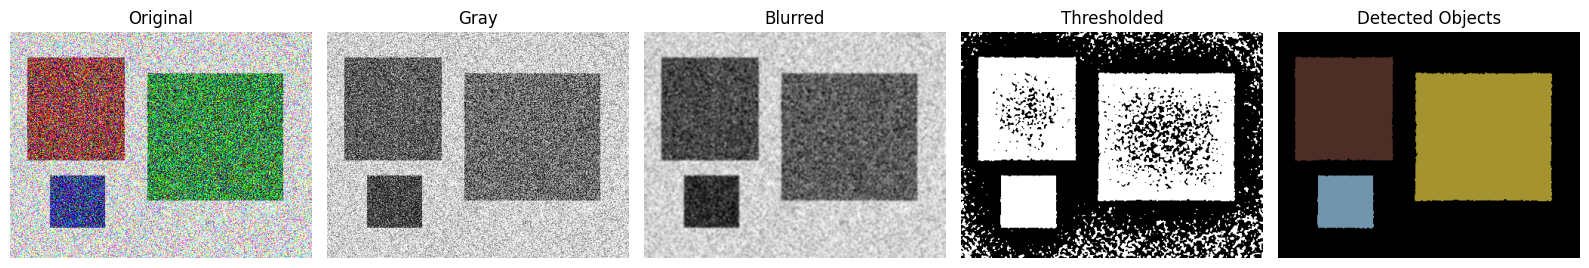

In [89]:
import numpy as np
import cv2
from random import randint

img = cv2.imread("images/fuzzy.png",1)

gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
blur = cv2.GaussianBlur(gray, (5,5), 0)

thresh = cv2.adaptiveThreshold(
	blur, 255,
	cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
	cv2.THRESH_BINARY_INV, 205, 1)

contours, hierarchy = cv2.findContours(
	thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
print(len(contours))

filtered = []
for c in contours:
	if cv2.contourArea(c) < 1000:
		continue
	filtered.append(c)
print(len(filtered))

objects = np.zeros([img.shape[0], img.shape[1], 3], 'uint8')
for c in filtered:
	col = (randint(0,255), randint(0,255), randint(0,255))
	cv2.drawContours(objects, [c], -1, col, -1)
	area = cv2.contourArea(c)
	print(area)

plot([img, gray, blur, thresh, objects],
     ["Original", "Gray", "Blurred", "Thresholded", "Detected Objects"])